Niklas E. Siedhoff<sup><em>1,§</em></sup>, Alexander-Maurice Illig<sup><em>1,§</em></sup>, Ulrich Schwaneberg<sup><em>1,2</em></sup>, Mehdi D. Davari<sup><em>1,*</em></sup>, <br>
PyPEF – an Integrated Framework for Data-driven Protein Engineering, <em>Journal of Chemical Information and Modeling</em> (2021) <br>
<sup><em>1</em></sup><sub>Institute of Biotechnology, RWTH Aachen University, Worringer Weg 3, 52074 Aachen, Germany</sub> <br>
<sup><em>2</em></sup><sub>DWI-Leibniz Institute for Interactive Materials, Forckenbeckstraße 50, 52074 Aachen, Germany</sub> <br>
<sup><em>*</em></sup><sub>Corresponding author</sub> <br>
<sup><em>§</em></sup><sub>Equal contribution</sub> <br>

# Can *in silico* directed evolution lead to improved variants?

Within this notebook we investigate if highly improved variants can be efficiently found using the statistical approach presented in the paper, which is based on the Metropolis-Hastings algorithm. To verify this, a model for an NK landscape is generated. The data for the NK landscape was published by Adam C. Mater, Mahakaran Sandhu, and Colin Jackson and is available under https://doi.org/10.1101/2020.09.30.319780. This landscape is then traversed using the algorithm and improved variants are collected. Since the exact fitness value for each variant is known, it can be checked whether variants can be found that have a fitness close to the global maximum.

Further, we make use of some tools presented in the above mentioned publication (https://github.com/acmater/NK_Benchmarking). These tools are licensed as follows:

BSD 3-Clause License

Copyright (c) 2020, Adam C. Mater
All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

1. Redistributions of source code must retain the above copyright notice, this
   list of conditions and the following disclaimer.

2. Redistributions in binary form must reproduce the above copyright notice,
   this list of conditions and the following disclaimer in the documentation
   and/or other materials provided with the distribution.

3. Neither the name of the copyright holder nor the names of its
   contributors may be used to endorse or promote products derived from
   this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from scipy.stats import pearsonr, spearmanr, norm
from sklearn.ensemble import RandomForestRegressor
from utils.landscape_class import Protein_Landscape

def StackedArrays(arr):
    """
    This function rearranges and splits the inputted array.
    As a result, X and y are returned that can be used for
    training or validating the model.
    """  
    X, y = arr.T
    
    return np.vstack(X), np.reshape(y, y.shape[0])

def GetXy(landscape):
    """
    This function takes in an NK landscape and returns
    the arrays that are necessary for generating and 
    validating a model.
    """
    
    X = landscape.tokenize_data()
    Y = landscape.data.T[1]
    boolians = landscape.boolean_mutant_array()
    
    variants = [[] for _ in range(6)]
    for x, y, boolian in zip(X, Y, boolians):
        substitutional_degree = 0
        for b in boolian:
            if b:
                substitutional_degree += 1
        variants[substitutional_degree].append([x, y])

    # Learn on up to triple substituted variants
    train_set = np.vstack(variants[0:4])
    
    # Test performance when predicting quadruple, quintuple substituted variants
    test_set = np.vstack(variants[4:])
    
    # Get X and y from the datasets
    X_train, y_train = StackedArrays(train_set)
    X_test, y_test = StackedArrays(test_set)
    
    return X_train, y_train, X_test, y_test

def Substitute(seq):
    """
    This function introduces randomly one substitution
    into the sequence of length 5 from the character
    pool 0-9. The variant with the respective substitution
    is returned.
    """
    var = seq.copy()
    pos = np.random.randint(5)
    aa = np.random.randint(10)
    var[pos] = aa
    
    return var

def Accept(seq, var):
    """
    This function allows to perform in silico DE
    by using the Metropolis-Hastings criterion.
    It takes a sequence and a variant as input and
    returns a boolian that can be used to decide,
    whether the variant, i.e., introduced substitution,
    is accept or not.
    """
    seq_fit = regr.predict([seq])
    var_fit = regr.predict([var])
        
    if var_fit >= seq_fit:
        return True
    
    else:
        # "Temperature"; can be adjusted
        T = 1e-2
               
        boltz = np.exp(((var_fit - seq_fit) / T), dtype=np.longfloat)
        p = min(1, boltz)
        
        rand_var = random.random()
        if rand_var < p:
            return True
        else:
            return False

## Importing and Pre-Processing the Data

At first, the data of the NK landscape provided in the '.txt' files need to be loaded. Then, the $10^5$ "sequence-fitness" pairs are either assigned to the training or validation set.

In [2]:
saved_nk_landscapes = {"NK-{}".format(x) : [Protein_Landscape(saved_file="K0/V{1}.txt".format(x,y)) for y in range(5)] for x in range(1)}
landscape = saved_nk_landscapes["NK-0"][0] # select the first landscape
fitness_dict = {str(k):v for k,v in zip(landscape.tokenize_data(), landscape.data.T[1])} #
fitness_values = np.fromiter(fitness_dict.values(), dtype=float)
X_train, y_train, X_test, y_test = GetXy(landscape)

print("Found %d sequence-fitness pairs."%(y_train.shape[0]+y_test.shape[0]))
print("Maximum fitness value: %.2f, minimum fitness value: %.2f"%(np.max(fitness_values), np.min(fitness_values)))

K0/V0.txt
K0/V1.txt
K0/V2.txt
K0/V3.txt
K0/V4.txt
Found 100000 sequence-fitness pairs.
Maximum fitness value: 0.90, minimum fitness value: 0.07


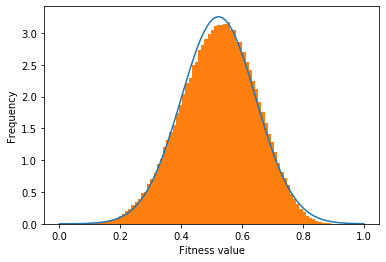

In [3]:
mean, std = norm.fit(fitness_values)
x = np.linspace(0, 1, 100)
y = norm.pdf(x, mean, std)
plt.plot(x, y)
plt.hist(fitness_values, density=True, bins=80)
plt.xlabel("Fitness value")
plt.ylabel("Frequency")
plt.show()

In [4]:
def Integral(x):
    y_all, x_all = np.histogram(fitness_values, bins=80, density=True)
    
    summe = 0.0
    for xi, yi in zip(x_all, y_all):
        if x >= xi:
            summe+=yi
        else:
            break
    
    return summe

## Generating a Predictive Model for the NK Landscape

Initialize and train regressor, e.g., random forest regressor. Further, determine performance of model.

In [5]:
regr = RandomForestRegressor(max_depth=100, n_estimators=1000, random_state=0)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

print("RF model achieved an R2 of %.2f, an Spearman's p of %.2f, and a Pearson's r of %.2f"%(r2_score(y_test, y_pred), spearmanr(y_test, y_pred)[0], pearsonr(y_test, y_pred)[0]))

RF model achieved an R2 of 0.78, an Spearman's p of 0.91, and a Pearson's r of 0.91


## *In silico* Directed Evolution
Perform *in silico* directed evolution as described in the paper. Stop when at least 10 steps were accepted.

In [6]:
for _ in range(20): # 20 different runs
    
    ys = []
    seq = np.random.randint(10, size=5)
    ys.append(regr.predict([seq]))

    accepted = 1
    while accepted <= 10:
        var = Substitute(seq)
        if Accept(seq, var):
            seq = var
            ys.append(regr.predict([seq]))
            accepted += 1
    fitness = fitness_dict[str(np.array(seq))]
    print("Fitness: %.2f, Within top: %.2e"%(fitness, 0.01*(100-Integral(fitness))))

Fitness: 0.77, Within top: 5.14e-02
Fitness: 0.79, Within top: 4.82e-02
Fitness: 0.68, Within top: 1.29e-01
Fitness: 0.75, Within top: 6.00e-02
Fitness: 0.84, Within top: 4.10e-02
Fitness: 0.77, Within top: 5.53e-02
Fitness: 0.65, Within top: 1.63e-01
Fitness: 0.73, Within top: 7.33e-02
Fitness: 0.79, Within top: 4.82e-02
Fitness: 0.83, Within top: 4.17e-02
Fitness: 0.72, Within top: 8.14e-02
Fitness: 0.73, Within top: 7.33e-02
Fitness: 0.81, Within top: 4.39e-02
Fitness: 0.80, Within top: 4.39e-02
Fitness: 0.82, Within top: 4.17e-02
Fitness: 0.74, Within top: 6.61e-02
Fitness: 0.80, Within top: 4.39e-02
Fitness: 0.69, Within top: 1.15e-01
Fitness: 0.70, Within top: 1.02e-01
Fitness: 0.84, Within top: 4.10e-02
